In [15]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

### Random d-Dimensional embeddings generation

In [16]:
# defining the minimum no of vectors allowed in a node
MIN_SUBSET_SIZE=5
DIMENSION = 2
N_VECTORS = 10000

In [17]:
# function to create a synthesized data
def generate_points(n,d):
    """ 
    generates n no of random vectors
    n : no of points to generate
    d : dimensionality of vectors

    """
    # defining the number of random embeddings (let us consider 1000 random embeddings)
    #n_vectors = 100
    #d = 10
    # initializing an empty list to store the embeddings
    vectors = []
    # generating 1000  random embeddings
    for i in range(n):
        # generate a random d-dim embeddings
        random_vector = [round(100 * random.random(), 2) for _ in range(d)]
        vectors.append(np.array(random_vector))
    return vectors

vectors = generate_points(N_VECTORS,DIMENSION)

### Implementing the ANNOY Tree

In [18]:
class Node:
    def __init__(self,hyperplane=None,constant=None,values=None):
        """
        PARAMETERS
        ----------
        hyperplane : the equation of the hyperplane equidistant from the two points
        constant   : the constant term in the hyperplane equation
        values     : the vectors to separate based on the hyperplane
        
        """
        self.hyperplane=hyperplane
        self.constant = constant
        self.values=values
        # vectors  that lie to the left hand side of the hyperplane
        self.left=None
        # vectors that lie to the right hand side of the hyperplane
        self.right=None

In [19]:
# find the equidistant point from the two given vectors
def hyperplane_equation(v1:np.ndarray,v2:np.ndarray):
    """
    returns the equation of the hyperplane equidistant from v1 and v2

    PARAMETERS
    ----------
    v1 : vector1 (numpy ndarray)
    v2 : vector2 (numpy ndarray)

    RETURNS
    -------
    normal_vector  : normal vector to the hyperplane (numpy ndarray)
    constant       : constant term in the hyperplane equation (float)
    
    """
    # asserting  that v1 and v2 are numpy arrays
    assert isinstance(v1, np.ndarray),    "v1 must be a numpy array"
    assert isinstance(v2, np.ndarray),    "v2 must be a numpy array"
    assert v1.shape == v2.shape,          "v1 and v2 must have the same shape"
    
    # finding the normal vector
    normal_vector = v2-v1
    # finding the midpoint
    midpoint = (v1+v2)/2
    # finding the const term
    constant = np.dot(normal_vector,midpoint)
    return normal_vector,constant


# checking which side of the hyperplane does the vector lies
def check_vector_side(normal_vector,constant,vector):
    """
    Returns the side to the hyperplane does the vector lies

    PARAMETERS
    -----------
    normal_vector   : the vector normal to the hyperplane (numpy ndarray)
    constant        : constant term in the hyperplane (float)
    vector          : the vector whose side we want to find (numpy ndarray)

    RETURNS
    -------
    side            : side of the hyperplane does vector lies (string)
    
    """

    # Assert that normal_vector and vector are numpy arrays
    assert isinstance(normal_vector, np.ndarray),    "normal_vector must be a numpy array"
    assert isinstance(vector, np.ndarray),           "vector must be a numpy array"
    
    # performing the dot product between the normal vector and vector
    result = np.dot(normal_vector,vector)
    if result<constant:
        side="right"
    else:
        side="left"
    return side

In [20]:
# testing the function
hyperplane_equation(vectors[0],vectors[1])

(array([-17.84,  -8.83]), -1016.0935500000004)

### Building the ANNOY Tree
Till both randomly selected vectors are same
1. Find random 2 vectors from the all given vectors in the set
2. Find a equidistant hyperplane between these two vectors
3. Put all the vectors that are right side to the hyperplane to a set called A
4. Put all the vectors that are left side to the hyperplane to a set called B
5. Repeat all previous steps in both set A and B recursively

In [21]:
# building the tree
def build_tree(vectors,min_subset_size):
    """
    Recursive function builds the KD-tree using the given list of vectors

    PARAMETERS
    ----------
    vectors          : list of all vectors
    min_subset_size  : minimum number of points to be in a region
    
    
    RETURNS
    -------
    cuurent_node    : the root node of the KD Tree
    
    """

    # assertion statements 
    assert isinstance(vectors, list),          "vectors must be a list"
    assert len(vectors) > 0,                   "vectors list cannot be empty"

    for vector in vectors:
        assert isinstance(vector, np.ndarray), "Each element in vectors must be a numpy array"

    assert isinstance(min_subset_size, int), "min_subset_size must be an integer"
    assert min_subset_size >= 0, "min_subset_size must be non-negative"

    # initializing values for random indices
    idx1 = 0
    idx2 = 0
    while idx1==idx2:
        # pick any two random numbers withing the number of vectors range 
        idx1 = random.randint(0,len(vectors)-1)
        idx2 = random.randint(0,len(vectors)-1)
        
     # pick any two random vectors from the list of vectors 
    first_vector = vectors[idx1]
    second_vector = vectors[idx2]
    
    # find the equidistant hyperplane between first vector and second vector
    hyperplane,constant = hyperplane_equation(first_vector,second_vector)
    # classfiy all vectors in the vectors list are on left or right with respect to hyperplane
    left_nodes=[]
    right_nodes=[]
    for vector in vectors:
        side = check_vector_side(hyperplane,constant,vector)
        # appending the vectors that lie to the right side of the hyperplane in right nodes
        if side=="right":
            right_nodes.append(vector)
        elif side=="left":
            left_nodes.append(vector)
            
    # building the current  node
    current_node = Node(hyperplane=hyperplane,constant=constant,values=vectors)
    
    # if the size of left node is greater than the min_subset_size (if so we need to split it further)
    if len(left_nodes)>min_subset_size:
        current_node.left = build_tree(left_nodes,min_subset_size)
    else:
        current_node.left = Node(values=left_nodes)

    # if the size of left node is greater than the min_subset_size (if so we need to split it further)
    if len(right_nodes)>min_subset_size:
        current_node.right = build_tree(right_nodes,min_subset_size)
    else:
        current_node.right = Node(values=right_nodes)

    return current_node

In [22]:
# testing the build tree function
test_tree = build_tree(vectors,MIN_SUBSET_SIZE)

### Traversing throught the tree to find the nearest neighbors

In [23]:
# searching for the nearest neighbors through tree
def search(tree,query_vector):
    """
    computes the nearest neighbors of the query vector by traversing through the ANNOY tree

    PARAMETERS
    ----------
    tree         : ANNOY tree built using build_tree function (class <Node>)
    query_vector : vector whose nearest neighbors we want to find (numpy ndarray)

    RETURNS
    -------
    tree.values  : nearest neighbors of query vectors (list)
    

    leaf node has three condition 
    1. the size of values attribute of the leaf node is less than the min_subset_size 
    2. the hyperplane attribute of the leaf node is None (as there is no hyperplane needed to split the node further if the first conditon is satisfied )
    3. the constant attribute of the leaf node is None  (as there is no hyperplane needed to split the node further if the first conditon is satisfied )
    
    """

    # Assertion statements 
    assert isinstance(tree, Node), "tree must be an instance of the Node class"
    assert isinstance(query_vector, np.ndarray), "query_vector must be a numpy array"
    assert len(tree.values) > 0, "tree.values cannot be empty"
    assert tree.values[0].shape == query_vector.shape, "query_vector must have the same dimensions as the vectors in the tree"

    
    # traversing till we reach leaves
    while len(tree.values)>MIN_SUBSET_SIZE and tree.hyperplane is not None and tree.constant is not None:
        # checking the side of the vector sample
        side = check_vector_side(tree.hyperplane,tree.constant,query_vector)
        if side=="left":  
            # print(f"go to left {len(tree.values)}")
            tree = tree.left
        elif side=="right":
            # print(f"go to right {len(tree.values)}")
            tree = tree.right
    
    return tree.values

In [24]:
# testing the search function
sample =  np.array([50 for _ in range(DIMENSION)])
nearest_neighbors = search(test_tree,sample)
print(nearest_neighbors)

[array([50.01, 49.91]), array([50.84, 50.7 ]), array([51.08, 50.29]), array([50.18, 49.87]), array([51.42, 51.09])]


In [43]:
from functools import reduce


def result(tree,query_vector,n=3):
    # defining an empty list to store the results 
    result = []
    # defining an empty list for storing KD Trees
    trees = []
    for i in range(n):
        # building a KD tree and searhcing for nearest neighbors
        i_tree = build_tree(vectors,MIN_SUBSET_SIZE)
        trees.append(i_tree)
        nearest_vectors = search(tree,query_vector)
        tupled_vectors = [tuple(vector) for vector in nearest_vectors]
        result.append(tupled_vectors)
        print(result,'\n')
    # eliminating duplicate
    result_final = list(reduce(lambda x, y: x+y,result))
    nearest_neighbors = [np.array(t) for t in set(result_final)] 
    return  nearest_neighbors

results,_ = result(test_tree,sample)

[[(50.01, 49.91), (50.84, 50.7), (51.08, 50.29), (50.18, 49.87), (51.42, 51.09)]] 

[[(50.01, 49.91), (50.84, 50.7), (51.08, 50.29), (50.18, 49.87), (51.42, 51.09)], [(50.01, 49.91), (50.84, 50.7), (51.08, 50.29), (50.18, 49.87), (51.42, 51.09)]] 

[[(50.01, 49.91), (50.84, 50.7), (51.08, 50.29), (50.18, 49.87), (51.42, 51.09)], [(50.01, 49.91), (50.84, 50.7), (51.08, 50.29), (50.18, 49.87), (51.42, 51.09)], [(50.01, 49.91), (50.84, 50.7), (51.08, 50.29), (50.18, 49.87), (51.42, 51.09)]] 



In [37]:
print(type(_[0]))

<class 'numpy.ndarray'>


In [26]:
results

[array([50.01, 49.91]),
 array([51.08, 50.29]),
 array([50.84, 50.7 ]),
 array([50.18, 49.87]),
 array([51.42, 51.09])]

### Visualizing 

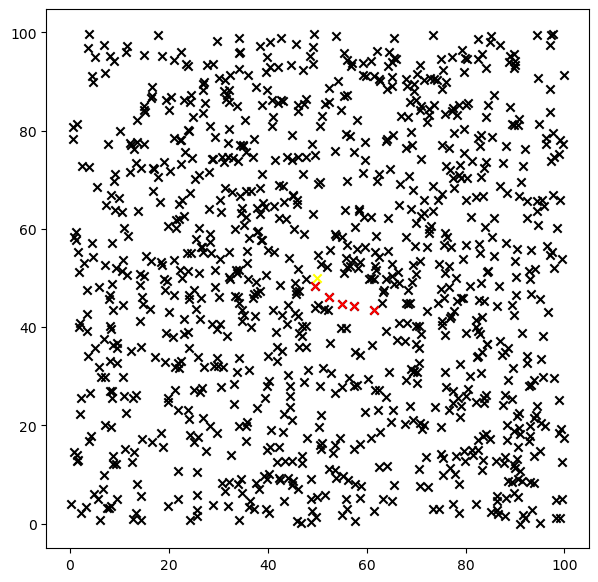

In [11]:
# visualizing the embeddings
fig = plt.figure(figsize=(7,7))
for i in range(N_VECTORS):
    plt.scatter(vectors[i][0],vectors[i][1],c="black",marker="x")
for j in nearest_neighbors:
    plt.scatter(j[0],j[1],c="red",marker="x")
    
plt.scatter(sample[0],sample[1],c="yellow",marker="x")
plt.show()

In [44]:
from scipy.spatial.distance import cosine, euclidean, cityblock
import numpy as np

def get_nearest_neighbors(vectors, query_vector, k=3, metric="cosine"):
    """
    Finds the K nearest neighbors from a given list of vectors.

    PARAMETERS
    ----------
    vectors : list of numpy.ndarray
        List of vectors to search for neighbors.
    query_vector : numpy.ndarray
        The vector whose nearest neighbors are to be found.
    k : int
        The number of nearest neighbors to find.
    metric : str
        The distance metric to use ('cosine', 'euclidean', 'manhattan').

    RETURNS
    -------
    nearest_neighbors : list of numpy.ndarray
        List of the k nearest neighbors.
    """

    # Dictionary to map metric names to functions
    metric_func = {
        "cosine": cosine,
        "euclidean": euclidean,
        "manhattan": cityblock
    }

    # Validate the metric
    if metric not in metric_func:
        raise ValueError(f"Unsupported metric: {metric}. Supported metrics are 'cosine', 'euclidean', 'manhattan'.")

    # Calculate distances from query_vector to all vectors
    distances = []
    for vector in vectors:
        distance = metric_func[metric](query_vector, vector)
        distances.append((distance, vector))

    # Sort the distances and get the top K nearest neighbors
    distances.sort(key=lambda x: x[0])
    nearest_neighbors = [vector for _, vector in distances[:k]]

    return nearest_neighbors

In [45]:
# Example usage
vectors = [np.random.rand(3) for _ in range(10)]  # Generating some random 3D vectors
query_vector = np.random.rand(3)

nearest_neighbors = get_nearest_neighbors(vectors, query_vector, k=3, metric="euclidean")
print(nearest_neighbors)

[array([0.49387174, 0.44421249, 0.15314018]), array([0.62327598, 0.30424154, 0.42882975]), array([0.49863603, 0.01072763, 0.47155407])]
